# Dam parametrisation Hanasaki et al 2006 


Based on: 
Hanasaki, N., Kanae, S., & Oki, T. (2006). A reservoir operation scheme for global river routing models. Journal of Hydrology, 327(1–2), 22–41. https://doi.org/10.1016/j.jhydrol.2005.11.011

Inne Vanderkelen -  January 2021


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

secprday=86400

## Load observations

In [37]:
# Load data from Yassin et al 2019
metadata = pd.read_csv('observations/reservoirs_metadata.csv')
metadata.index = metadata['name']

# select reservoir name
reservoir_name = 'Bhumiboi' # possible to replace by: Dickson, Bhumiboi, Waterton, Glen_canyon, Palisades, Trinity, Semione, Sirikit
reservoir_name = "Dickson"
#reservoir_name = "Glen_canyon"
#reservoir_name = 'Waterton'
purpose = metadata.loc[reservoir_name].purpose
max_storage = metadata.loc[reservoir_name].capacity_mcm*10**6

dead_storage = 0.4
# load observations
fn = 'observations/res_info_out_'+reservoir_name+'.csv'
df = pd.read_csv(fn)
df.index = pd.to_datetime(df.timed)

outflow_obs = df['outflow']
storage_obs = df['stoobs']
inflow = df['inflow']


## Parameters required for Hanasaki
Necessary parameters in MizuRoute per reservoir: 
- reservoir purpose (1)
- max storage (1)
- monthly inflow (12) (maybe possible to log monthly inflow for 5 years + calculate total annual outflow based on this?)
- for irrigation reservoirs: monthly irrigation demand (12) (I think eventually this will be communicated from CLM in coupling?) 

input: 
- (daily) inflow

output: 
- (daily) outflow

In [38]:
# average inflow (Hanasaki uses naturalised inflow)
# tbd how to do in MizuRoute (e.g. log mean monthly inflow inflow of last 20 or 5 years, e.g. Droppers et al., 2020)

# here taken as mean over whole observational period
mean_inflow = inflow.mean() # (m³/s)

mean_inflow_monthly = inflow.groupby([inflow.index.month]).mean() # to adjust for seasonal cycle (m³/s)

# total annual inflow
mean_inflow_yearly = mean_inflow_monthly.mean() # m³/s
 
c = max_storage/(mean_inflow_yearly * secprday * 365) #[m³/yr] # if c>0.5 : large reservoir, if c < 0.5: "whitin-a-year" reservoir, if c = 0, reservoir is "run-of-the-river"

print('reservoir = '+reservoir_name)
print("purpose = "+purpose)
print("c = %.2f" %c)
print("mean annual inflow = %.0f m³/s" %mean_inflow_yearly)

reservoir = Dickson
purpose = watersupply
c = 0.18
mean annual inflow = 36 m³/s


In [39]:
# irrigation demand - leave out for now. 
# monthly irrigation demand to the reservoir
demand_irrig_monthly = np.zeros(12) # [m³/s] 
#demand_irrig_monthly = np.array([0,0,0,50,50,50,50,50,0,0,0,0,])

if reservoir_name == "Bhumiboi": demand_irrig_monthly = np.array([0,150,200,250,200,75,50,50,20,0,30,0])
if reservoir_name == "Sirikit" : demand_irrig_monthly = np.array([0,50,100,200,100,50,20,50,10,10,0,0])
if reservoir_name == "Waterton": demand_irrig_monthly =  np.array([0,0,5,30,50,50,30,20,5,0,0,0])# estimated demand (to test demand > inflow * erf)

# determine daily irrigation demand (by interpolating estimated monthly demand)

from scipy.interpolate import interp1d
interp = interp1d(np.linspace(0,11, num=12), demand_irrig_monthly, kind='cubic')
demand_irrig_daily = interp(np.linspace(0,11, num=366))

# mean annual irrigation demand to reservoir (calculated based on last 20 years (Biemans) or 5 years (Droppers et al.) 
demand_irrig_annual = np.mean(demand_irrig_daily) # [m³/s] also possible to include domestic and industrial demand. 



In [40]:
# constants for Hanasaki parametrisation

# how much of total storage is active
alpha = 0.85 # nondimensional constant

# evironmental flow requirement EFR factor (how much of annual inflow is required for release)
# only important for meeting irrgation demands
# Hanasaki uses 0.5, later studies use 0.1 Biemans et al., 2011; Voisin et al., 2013 to avoid excessive releases and increasing irrigation water availability
# Droppers et al calculated erf seperately
erf_factor = 0.9 # 0.1



### Determine start operational year
when monthly inflow < annual average inflow, i.e. start of the release period. 

tbd how to determine this within MizuRoute or take as a parameter for each reservoir?
I think not way to go, would require to have this info for each reservoir

In [41]:
# extract one hydrological year - this can be done more efficiently
inds_recharge = (mean_inflow_monthly>mean_inflow_yearly) # recharge months
inds_release = (mean_inflow_monthly<mean_inflow_yearly) # release months

ind_first_recharge = np.where(inds_recharge.cumsum()==1)[0].item()
ind_first_release = inds_release[ind_first_recharge:].cumsum()==1

start_month = ind_first_release[ind_first_release == True].index.item()

# reconfigure input year to operational years

start_date = str(inflow.index.year[0])+'-'+str(start_month)+'-01'
#inflow = inflow[start_date:]

print(start_date)

2005-10-01


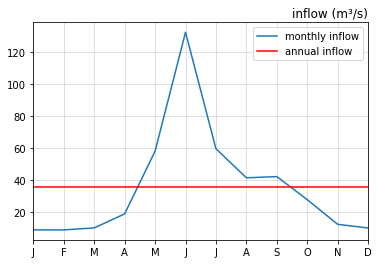

In [42]:
# plot mean outflow cycle
mean_inflow_monthly.plot()
plt.axhline(y=mean_inflow, color = 'r')
plt.title('inflow (m³/s)', loc='right')
plt.legend(['monthly inflow', 'annual inflow'])
plt.xticks(np.arange(1,13),['J','F','M','A','M','J','J','A','S','O','N','D']);
plt.xlabel(' ')
plt.grid(alpha=0.5)
plt.xlim([1,12]);

### Hanasaki parametrisation

In [43]:

# initialise empty data series
release_monthly = pd.Series(index=inflow.index, dtype='float64')
storage = pd.Series(index=inflow.index, dtype='float64')
E_time_series = pd.Series(index=inflow.index, dtype='float64')

# assign start value of storage 
# MizuRoute implementation to limit n parameters: use maximum capacity and let reservoir empty during spin up? to test)
#storage[0] = max_storage
# initialise storage 
S = 0

# determine initial release coefficient
release_coef = S/(alpha*max_storage) # how filled the reservoir is at start of year

# loop over timesteps (days)
for t, inflow_day in enumerate(inflow): 

    # add inflow to storage
    S = S  + inflow[t]*secprday
    
    ### 1. Determine release coefficient
    # based on storage at beginning of year to smooth out intra-annual fluctuations
    
    
    # when it is the first day of a operational year, determine release coeficient based on current storage
    
    if inflow.index[t].month == start_month and inflow.index[t].day == 1: 
        release_coef = S/(alpha*max_storage) # how filled the reservoir is at start of year

    ### 2. Determine targetted monthly release (based on purpose)

    # non-irrigation reservoirs
    if purpose != 'irrigation': 
        release_monthly_tar = mean_inflow_yearly # m³/s
        # irrigation reservoirs - based on Biemans et al., ignoring industrial and domestic water withdrawal (for now)
    else: 
        # check water demand based on EFR

        if demand_irrig_annual >= erf_factor * mean_inflow_yearly: # more is demanded than then can be provided based on EFR

            release_monthly_tar = mean_inflow_monthly[inflow.index[t].month]*0.1 + 0.9 * mean_inflow_yearly * demand_irrig_daily[inflow.index[t].dayofyear-1]/demand_irrig_annual

        elif demand_irrig_annual < erf_factor * mean_inflow_yearly: 
            release_monthly_tar = mean_inflow_yearly + demand_irrig_daily[inflow.index[t].dayofyear-1] - demand_irrig_annual 
    
    ### 3. Determine actual reservoir release 
    # adjust target release based on how filled the reservoir is; depending on relative size of reservoir (c)
    
    if c >= 0.5: # large reservoir
        release_monthly[t] = release_monthly_tar * release_coef

    elif  0 <= c and c < 0.5: # whitin-a-year reservoir - release influenced by monthly inflow 
        release_monthly[t] = (c/0.5)**2 * release_coef * release_monthly_tar + (1-(c/0.5)**2)*inflow_day
    
    # scaling of the daily release based on the sotrage in comparison with the dead storage
    # 1. adjust release so that reservoir does not empty (S goes below dead storage, can be defined as 0.1 of maximum storage, e.g. Biemans 2011, or as 0)
    # this introduces yet another parameter though ... What do you think? 
    # I see you already accounted for this in the lake code
    if S < max_storage * dead_storage: # if reservoir storage falls below the dead storage, subtract the difference from the daily release value 
        release_monthly[t] = release_monthly[t] - (max_storage * dead_storage - S) / (86400)
    # 2. Adjust release to account for spilling releases (storage exceeds max storage, all abundant water is released)    
    elif S > max_storage: 
        release_monthly[t] = release_monthly[t] + (S - max_storage)  / (86400)
    
    # adjust storage based on inflow and outflow of day
    S = S -(release_monthly[t])*secprday
        
        
    # fill storage array
    storage [t] = S

# Save of the model output

In [44]:
# save the file
result = pd.DataFrame()
result ['Storage_Hanasaki'] =  storage
result ['Outflow_Hanasaki'] =  release_monthly
result ['Storage_Observed'] =  np.array(df['stoobs'])
result ['Outflow_Observed'] =  np.array(df['outflow'])
result ['Inflow_Observed']  =  np.array(df['inflow'])
result.index = df.index
print(result)
result.to_csv('Hanasaki_Inne_'+reservoir_name+'.csv')

            Storage_Hanasaki  Outflow_Hanasaki  Storage_Observed  \
timed                                                              
2005-01-01      8.092787e+07       -933.045183      1.827041e+08   
2005-01-02      8.099929e+07          5.535347      1.818813e+08   
2005-01-03      8.107117e+07          5.570150      1.810601e+08   
2005-01-04      8.114306e+07          5.571890      1.802089e+08   
2005-01-05      8.121347e+07          5.457041      1.792809e+08   
...                      ...               ...               ...   
2011-12-27      1.541328e+08         11.753885      1.771340e+08   
2011-12-28      1.538005e+08         11.475465      1.766342e+08   
2011-12-29      1.534700e+08         11.605975      1.760414e+08   
2011-12-30      1.531317e+08         11.005630      1.754650e+08   
2011-12-31      1.527863e+08         10.457490      1.748895e+08   

            Outflow_Observed  Inflow_Observed  
timed                                          
2005-01-01         

### Döll natural lake parametrisation - for comparison

In [45]:

# initialise empty data series
release_monthly_lake = pd.Series(index=inflow.index, dtype='float64')
storage_lake = pd.Series(index=inflow.index, dtype='float64')

# assign first storage (possible for spin up: use maximum capacity and let reservoir empty during spin up)
storage_lake[0] = storage_obs[start_month]
#storage[0] = max_storage

release_monthly[0] = inflow[0]

# loop over timesteps (days)
for t, inflow_day in enumerate(inflow): 

    # adjust storage based on inflow and outflow of day
    if t > 0:
        storage_lake[t] = storage_lake[t-1] + (inflow_day-release_monthly_lake[t-1])*secprday
    
    release_coef = 0.01/secprday #[day-1]
    release_monthly_lake[t] = release_coef  * storage_lake[t] * (storage_lake[t]/max_storage)**1.5
    



### Wisser et al 2010
simple relationship of reservoir inflow and mean reservoir inflow to determine reservoir outflow

In [46]:

# initialise empty data series
release_monthly_wisser = pd.Series(index=inflow.index, dtype='float64')
storage_wisser = pd.Series(index=inflow.index, dtype='float64')

# assign first storage (possible for spin up: use maximum capacity and let reservoir empty during spin up)
storage_wisser[0] = storage_obs[start_month]
#storage[0] = max_storage

release_monthly_wisser[0] = inflow[0]

# define constants (empirically determined, see Wisser et al 2010)
c1 = 0.16
c2 = 0.6

# loop over timesteps (days)
for t, inflow_day in enumerate(inflow): 

    # adjust storage based on inflow and outflow of day
    if t > 0:
        storage_wisser[t] = storage_wisser[t-1] + (inflow_day-release_monthly_wisser[t-1])*secprday
    
    # check inflow compared to average inflow
    if inflow_day >= mean_inflow_yearly:
        release_monthly_wisser[t] = c1*inflow_day
    elif inflow_day < mean_inflow_yearly:
        release_monthly_wisser[t] = c2*inflow_day + (mean_inflow_yearly-inflow_day)
    

### Plot resulting outflow 

In [47]:
# print information on reservoir loaded

print('Observations for '+reservoir_name)
print('purpose: '+purpose)
print('capacity: %d m³' %max_storage)
print('c = %0.2f' %c)
print('start date of operational year: '+start_date)
print('end date of observation period: '+ str(inflow.index.year[-1])+'-'+str(inflow.index.month[-1])+'-'+str(inflow.index.day[-1]))

Observations for Dickson
purpose: watersupply
capacity: 203000000 m³
c = 0.18
start date of operational year: 2005-10-01
end date of observation period: 2011-12-31


In [48]:
# set plotting parameters
def set_plot_param():
    """Set my own customized plotting parameters"""
    
    import matplotlib as mpl
    mpl.rc('xtick',labelsize=16)
    mpl.rc('ytick',labelsize=16)
    mpl.rc('axes',titlesize=18)
    mpl.rc('axes',labelsize=16)
    mpl.rc('axes',edgecolor='grey')
    mpl.rc('grid', color='lightgray')
    mpl.rc('legend',fontsize=16, frameon=False)
set_plot_param()

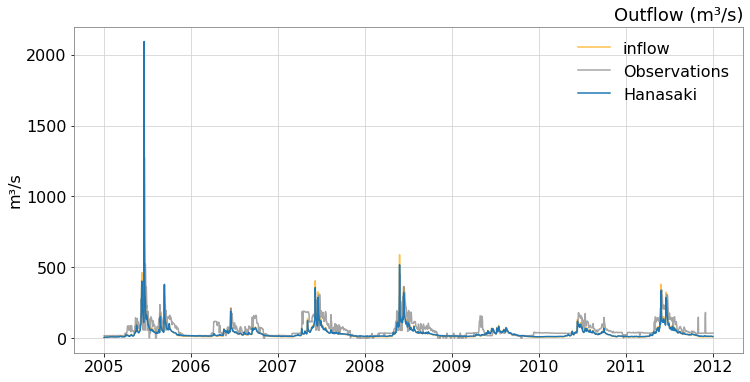

In [49]:
fig, axs = plt.subplots(1,1,figsize=(12,6))

plt.plot(inflow, label='inflow', color='orange', alpha = 0.7)
plt.plot(outflow_obs, color='gray', label='Observations', alpha=0.7)
plt.plot(release_monthly, label='Hanasaki')

#plt.plot(release_monthly_lake, label="Döll")
#plt.plot(release_monthly_wisser, alpha=0.5, label="Wisser")

plt.title('Outflow (m³/s)', loc='right')
plt.ylabel('m³/s')
plt.grid()
plt.legend();


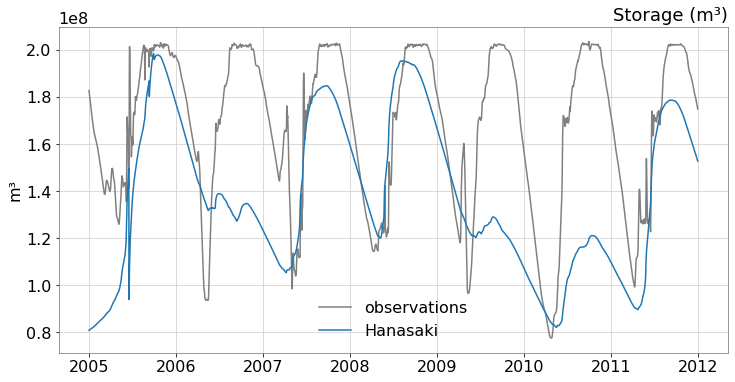

In [50]:
# storage
fig, axs = plt.subplots(1,1,figsize=(12,6))

#plt.plot(storage_lake, label="Döll")
plt.plot(storage_obs, color='gray', label='observations')
plt.plot(storage, label="Hanasaki")
#plt.plot(storage_wisser, label="Wisser")

plt.title('Storage (m³)', loc='right')
plt.ylabel('m³')

plt.legend();
plt.grid()

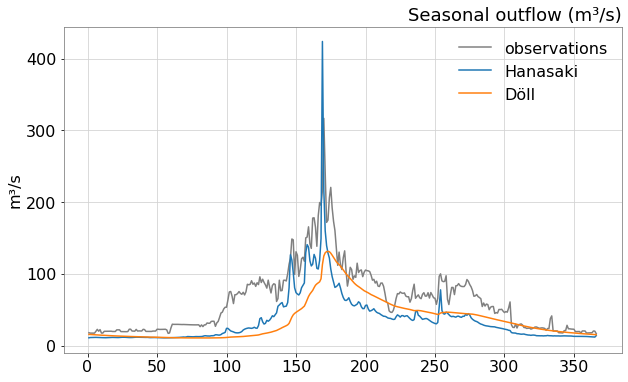

In [51]:
fig, axs = plt.subplots(1,1,figsize=(10,6))

## determine start of operational year for each calendar year
# when monthly inflow drops below average annual inflow
plt.plot(outflow_obs.groupby(release_monthly_lake.index.dayofyear).mean(), color='gray', label="observations")
plt.plot(release_monthly.groupby(release_monthly_lake.index.dayofyear).mean(), label="Hanasaki")
#plt.plot(release_monthly_wisser.groupby(release_monthly_lake.index.dayofyear).mean(), label="Wisser")
plt.plot(release_monthly_lake.groupby(release_monthly_lake.index.dayofyear).mean(), label="Döll")

plt.ylabel('m³/s')
plt.title('Seasonal outflow (m³/s)', loc='right')
plt.plot()
plt.legend();
plt.grid()



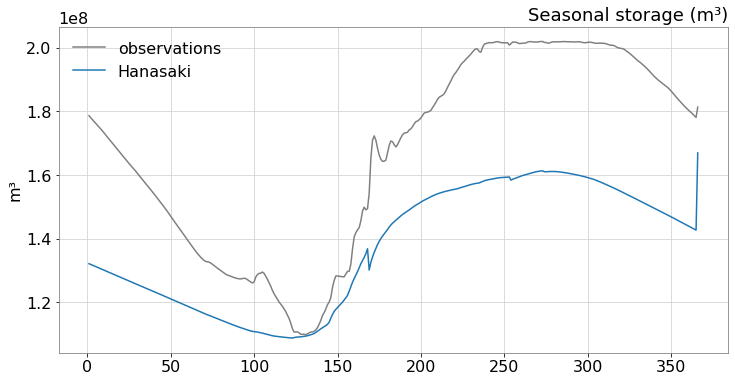

In [52]:
# seasonal cycle of storage
fig, axs = plt.subplots(1,1,figsize=(12,6))

plt.plot(storage_obs.groupby(storage_lake.index.dayofyear).mean(), color='gray', label="observations")
plt.plot(storage.groupby(storage.index.dayofyear).mean(), label="Hanasaki")
#plt.plot(storage_wisser.groupby(storage_wisser.index.dayofyear).mean(), label='Wisser')
#plt.plot(storage_lake.groupby(storage_lake.index.dayofyear).mean(), label="Döll")

plt.title('Seasonal storage (m³)', loc='right')
plt.ylabel('m³')
plt.grid()
plt.legend();

In [53]:
# RMSE
def rmse(simulations,observations):
    return np.sqrt(((simulations - observations) ** 2).mean())

rmse_hanasaki = rmse(release_monthly,outflow_obs)
rmse_natural_lake = rmse(release_monthly_lake,outflow_obs)
rmse_wisser = rmse(release_monthly_wisser,outflow_obs)

print("RMSE outflow natural lake: %0.2f" %rmse_natural_lake)
print("RMSE outflow hanasaki: %0.2f" %rmse_hanasaki)
print("RMSE outflow wisser: %0.2f" %rmse_wisser)


RMSE outflow natural lake: 56.08
RMSE outflow hanasaki: 58.17
RMSE outflow wisser: 79.19


## Plots for presentation

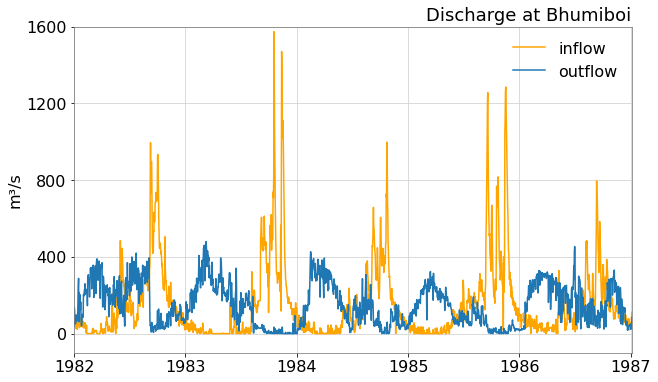

In [44]:
# Bhumiboi
fig, axs = plt.subplots(1,1,figsize=(10,6))

plt.plot(inflow, label='inflow', color='orange')
plt.plot(outflow_obs, label='outflow')
#plt.plot(release_monthly, label='Hanasaki')

#plt.plot(release_monthly_lake, label="Döll")
#plt.plot(release_monthly_wisser, alpha=0.5, label="Wisser")

plt.title('Discharge at '+reservoir_name , loc='right')
plt.ylabel('m³/s')
plt.grid()
plt.xlim([inflow.index[365*start],inflow.index[365*start+nyear*366]])
plt.yticks([0,400,800,1200,1600])
plt.ylim([-100,1600])
plt.legend();


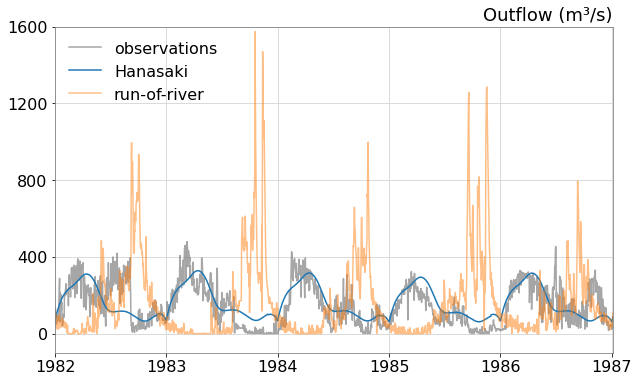

In [71]:
fig, axs = plt.subplots(1,1,figsize=(10,6))
plt.plot(outflow_obs, color='gray', label='observations', alpha=0.7)
plt.plot(release_monthly, label='Hanasaki')
plt.plot(inflow, label="run-of-river", alpha=0.5)

#plt.plot(release_monthly_lake, label="natural lake")

#plt.plot(release_monthly_wisser,, label="Wisser")
plt.xlim([inflow.index[365*start],inflow.index[365*start+nyear*366]])
plt.yticks([0,400,800,1200,1600])
plt.ylim([-100,1600])
plt.title('Outflow (m³/s)', loc='right')
plt.grid()
plt.legend();


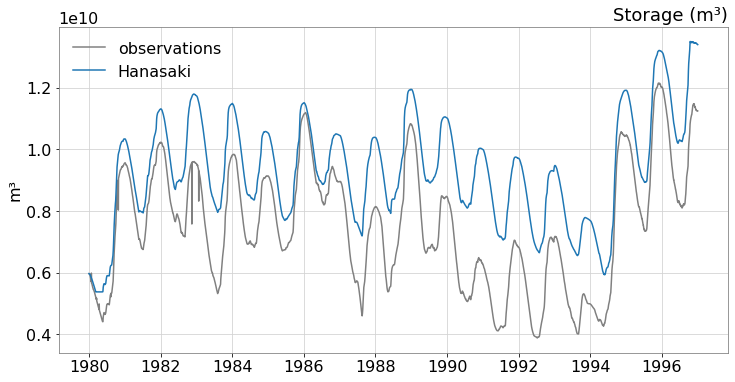

In [77]:
# storage
fig, axs = plt.subplots(1,1,figsize=(12,6))

plt.plot(storage_obs, color='gray', label='observations')
plt.plot(storage, label="Hanasaki")
#plt.plot(storage_lake, label="Döll (natural lake)")

#plt.plot(storage_wisser, label="Wisser")

plt.title('Storage (m³)', loc='right')
plt.ylabel('m³')

plt.legend();
plt.grid()

(13149.0, 14613.0)

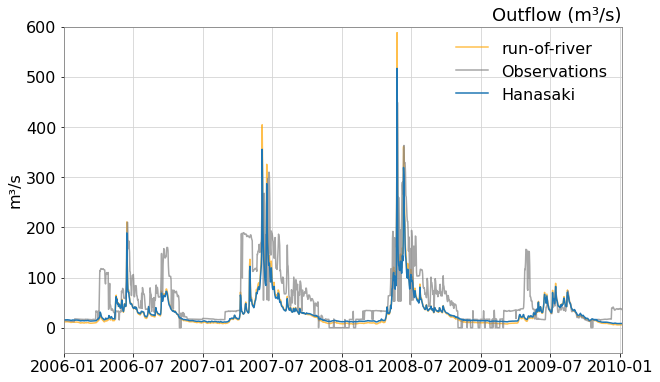

In [101]:
# Dickson

fig, axs = plt.subplots(1,1,figsize=(10,6))

plt.plot(inflow, label='run-of-river', color='orange', alpha = 0.7)
plt.plot(outflow_obs, color='gray', label='Observations', alpha=0.7)
plt.plot(release_monthly, label='Hanasaki')

#plt.plot(release_monthly_wisser, alpha=0.5, label="Wisser")
nyear=4
start=1
plt.title('Outflow (m³/s)', loc='right')
plt.ylabel('m³/s')
plt.xtick()
plt.grid()
plt.ylim([-50,600])
plt.legend();
plt.xlim([inflow.index[365*start],inflow.index[365*start+nyear*366]])


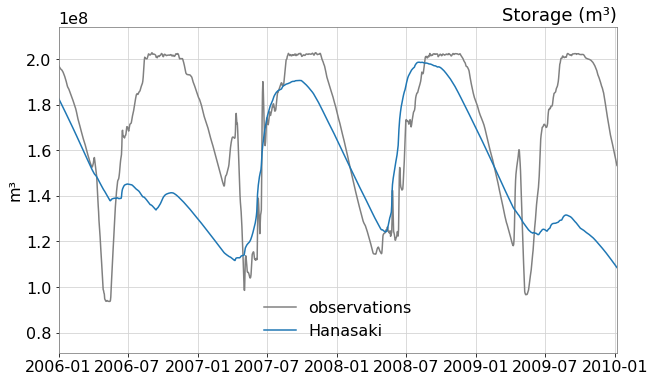

In [102]:
# storage
fig, axs = plt.subplots(1,1,figsize=(10,6))

#plt.plot(storage_lake, label="Döll")
plt.plot(storage_obs, color='gray', label='observations')
plt.plot(storage, label="Hanasaki")
#plt.plot(storage_wisser, label="Wisser")

plt.title('Storage (m³)', loc='right')
plt.ylabel('m³')
plt.xlim([inflow.index[365*start],inflow.index[365*start+nyear*366]])

plt.legend();
plt.grid()